# Feature 따른 예측값 변화 PDP, ICE

# 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

# 데이터 불러오기

In [2]:
data = pd.read_csv('./data/attrition2.csv')
data.head()

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1


|	변수 명	|	내용	|	구분	|  
|	----	|	----	|	----	|  
|	**Attrition**	|	이직여부, Yes = 1 , No = 0	|	**Target**	|  
|	Age	|	나이	|	숫자	|  
|	BusinessTravel	|	출장 빈도(범주)	|		|  
|	Department	|	현 부서	|		|  
|	DistanceFromHome	|	집-직장 거리(마일)	|	숫자	|  
|	Education	|	교육수준(범주)	|	1 Below College, 2 College, 3 Bachelor, 4 Master, 5 Doctor	|  
|	EducationField	|	전공	|		|  
|	EnvironmentSatisfaction	|	근무환경에 대한 만족도(범주)	|	1 Low, 2 Good, 3 Excellent, 4 Outstanding	|  
|	Gender	|	성별	|		|  
|	JobInvolvement	|	직무 적극성(참여도)	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	JobRole	|	직무	|		|  
|	JobSatisfaction	|	직무 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	MaritalStatus	|	결혼상태	|		|  
|	MonthlyIncome	|	월급	|	숫자	|  
|	NumCompaniesWorked	|	현재까지 근무한 회사 수	|	숫자	|  
|	PercentSalaryHike	|	전년대비 급여인상율(%)	|	숫자	|  
|	RelationshipSatisfaction	|	동료와의 관계 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	StockOptionLevel	|	스톡옵션 수준 0~3	|	범주	|  
|	TotalWorkingYears	|	총 근무 연수	|	숫자	|  
|	TrainingTimesLastYear	|	전년 교육훈련 횟수	|	숫자	|  
|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	1 Bad, 2 Good, 3 Better, 4 Best	|  
|	YearsAtCompany	|	현직장 근무 연수	|	숫자	|  
|	YearsInCurrentRole	|	현직무 연수	|	숫자	|  
|	YearsWithCurrManager	|	현 팀장과 근무한 연수	|	숫자	|  


# 필요한 함수 정의하기

In [3]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

# 데이터 준비하기

##### 1) x, y로 나누기

In [4]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [5]:
y.value_counts(normalize = True)

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

##### 2) 가변수화

In [6]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','MaritalStatus']
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True)

##### 3) train : validation 분할

In [7]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2023)

In [8]:
print(x_train.shape, x_val.shape)

(920, 32) (230, 32)


##### class balance를 맞추기 위한 resampling

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

# 모델 생성

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

# PDP, ICE

In [13]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

## 1. 개별 변수 분석하기

* feature 1 : 'MonthlyIncome'

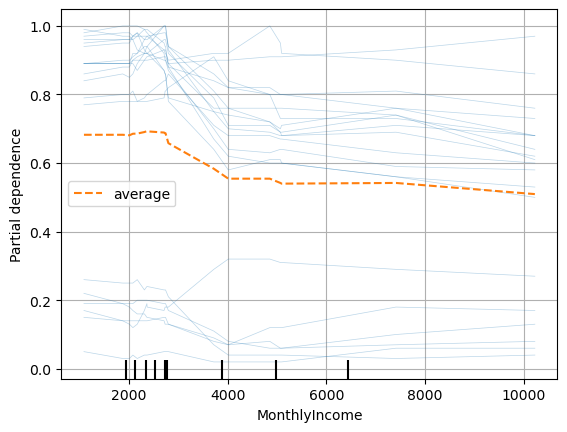

In [31]:
var = 'MonthlyIncome'
PartialDependenceDisplay.from_estimator(model, data20, [var], kind="both")
plt.grid()
plt.show()

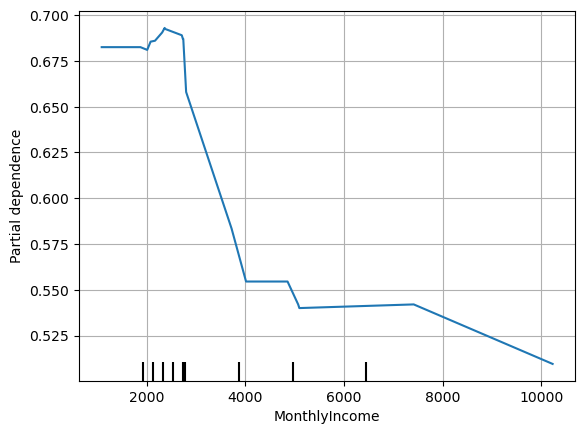

In [32]:
var = 'MonthlyIncome'
PartialDependenceDisplay.from_estimator(model, data20, [var])
plt.grid()
plt.show()

* feature 2 : 'MaritalStatus_Married'

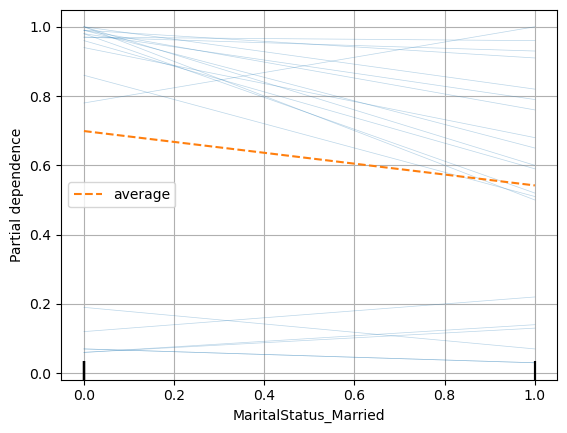

In [27]:
var = 'MaritalStatus_Married'
PartialDependenceDisplay.from_estimator(model, data20, [var], kind="both")
plt.grid()
plt.show()

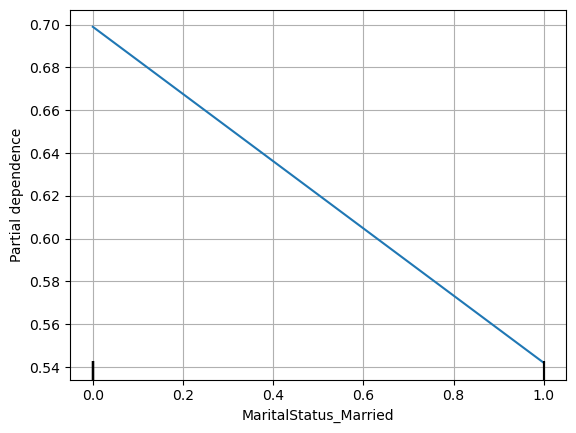

In [33]:
var = 'MaritalStatus_Married'
PartialDependenceDisplay.from_estimator(model, data20, [var])
plt.grid()
plt.show()

* feature 3 : 'DistanceFromHome'

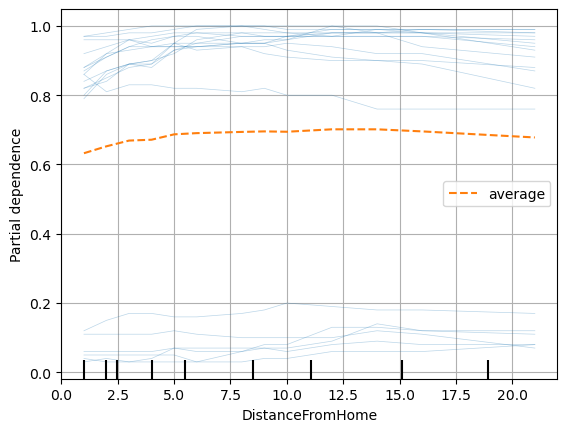

In [28]:
var = 'DistanceFromHome'
PartialDependenceDisplay.from_estimator(model, data20, [var], kind="both")
plt.grid()
plt.show()

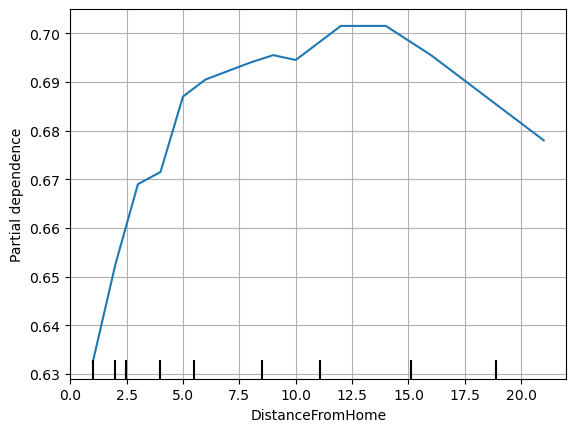

In [34]:
var = 'DistanceFromHome'
PartialDependenceDisplay.from_estimator(model, data20, [var])
plt.grid()
plt.show()

* feature 4 : 'JobSatisfaction'

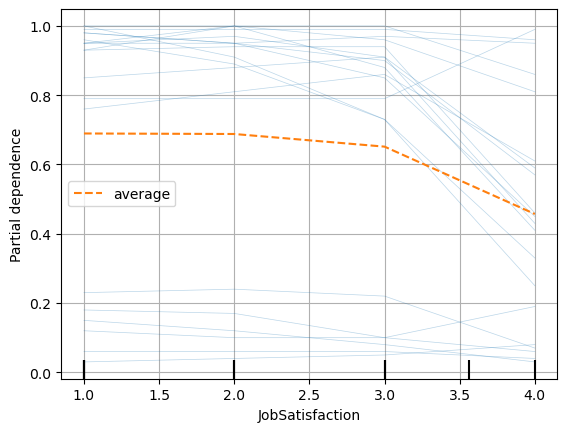

In [29]:
var = 'JobSatisfaction'
PartialDependenceDisplay.from_estimator(model, data20, [var], kind="both")
plt.grid()
plt.show()

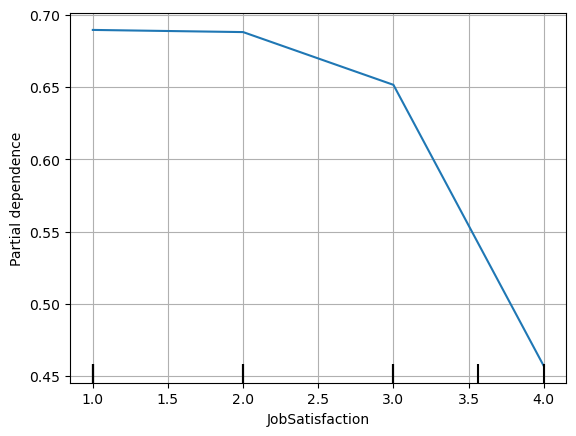

In [35]:
var = 'JobSatisfaction'
PartialDependenceDisplay.from_estimator(model, data20, [var])
plt.grid()
plt.show()

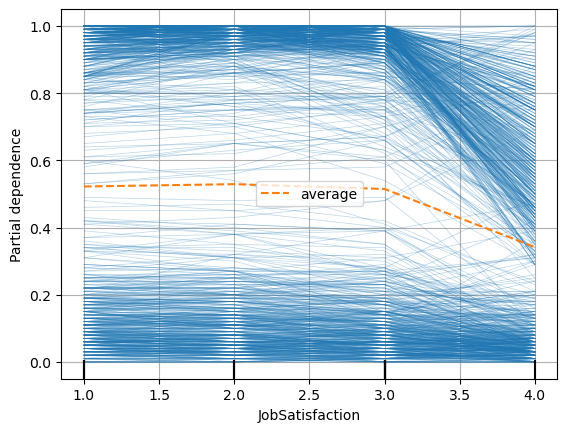

In [36]:
PartialDependenceDisplay.from_estimator(model,
                                        x_train,
                                        ['JobSatisfaction'],
                                        kind="both")
plt.grid()
plt.show()

## 2. 두 변수와 예측값 비교하기

* 조합1 : 'MonthlyIncome','MaritalStatus_Married'

In [ ]:
PartialDependenceDisplay.from_estimator(model, x_train, ['rm','lstat'])
plt.show()

In [ ]:
PartialDependenceDisplay.from_estimator(model, x_train, [('rm','lstat')])
plt.show()

* 조합2 : 'DistanceFromHome','JobSatisfaction'